# Laplace Approximation
This script implements an uncertainty estimation method based on Laplace approximation. The majority of the code is reused from svicnn.ipynb and just slightly adapted to accommodate for Laplace approximation. The method is once again demonstrated on MNIST.

## Import some necessary packages

In [1]:
import tqdm
import torch
import torch.nn as nn

from torch.nn.parameter import Parameter
from torch.distributions.normal import Normal
from util.dataset import make_mnist
from torch.optim import Adam
from torch.utils.data import DataLoader
from util.util import show_images, run_model_on_data

## Laplace approximation
As in the setting of stochastic variational inference we like to determine the posterior distribution $p(\theta|D)$ and acknowledge that we simply cannot compute it exactly. We therefore aim to approximate it once again by some distribution $q(\theta)$. Contrary to the former, the central idea of Laplace approximation is to find the maximum a posteriori (MAP) solution $\theta^*$ and subsequently compute the Taylor expansion around $\log p(\theta^*|D)$. Dropping terms of higher order than two this is

$$
\log p(\theta|D) \approx q(\theta) = \log p(\theta^*|D) - \frac{1}{2}(\theta - \theta^*)^T \bar H (\theta - \theta^*)
$$

where the first order term vanishes since we chose $\theta^*$ to be at a maximum and $\bar H=\mathbb{E}[H]$ is the average Hessian of the negative log posterior. Exponentiating above equation shows the right-hand side to be of Gaussian functional form for $\theta$. We thus approximate the posterior with a normal distribution

$$
\theta \sim \mathcal{N}(\theta^*, \bar H^{-1})
$$

with the inverted Hessian matrix as our covariance matrix $\bar H^{-1}$.

Just like in the SVI setting, we can then sample from $q(\theta)$ where the variance in predictions provides a notion of uncertainty.

A significant difference to SVI is therefore that we need not customize our network layers - we can simply employ a pretrained network and determine $\bar H$ thereafter. The central question at this point is how to compute $\bar H$. A later section in this notebook will take care of this. First, let's design a network.

## Building a network for Laplace approximation
Conceptually, we need not customize any network layers but may just use the basic ones provided by any deep learning framework. However, for convenience, let's customize a linear as well as a convolutional layer to take care of the network parameter sampling. All the below code does is introducing a callable in these layers which will take care of sampling from a Gaussian distribution with mean $\theta^*$.

In [2]:
class Linear(nn.Module):
    def __init__(self, 
              in_features, 
              out_features, 
              weight_sampler=lambda x: x,
              bias_sampler=lambda x: x):
        super(Linear, self).__init__()
        
        # Weights
        self.weight = Parameter(torch.rand(out_features, in_features) - 0.5)
        self.weight_sampler = weight_sampler
        
        # Bias
        self.bias = Parameter(torch.rand(out_features) - 0.5)
        self.bias_sampler = bias_sampler
        
    def forward(self, x):
        weight = self.weight_sampler(self.weight)
        bias = self.bias_sampler(self.bias)
        return nn.functional.linear(x, weight, bias=bias)
    
    
class Conv2d(nn.Module):
    def __init__(self,
              in_channels, 
              out_channels, 
              kernel_size,
              weight_sampler=lambda x: x,
              bias_sampler=lambda x: x):
        super(Conv2d, self).__init__()
        
        # Weights
        self.weight = Parameter(torch.rand(out_channels, in_channels, kernel_size, kernel_size) - 0.5)
        self.weight_sampler = weight_sampler
        
        # Bias
        self.bias = Parameter(torch.rand(out_channels) - 0.5)
        self.bias_sampler = bias_sampler
        
            
    def forward(self, x):
        weight = self.weight_sampler(self.weight)
        bias = self.bias_sampler(self.bias)
        return nn.functional.conv2d(x, weight, bias=bias)


class LaplaceCNN(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = Conv2d(1, 16, kernel_size=5)
        self.conv2 = Conv2d(16, 32, kernel_size=5)
        self.linear1 = Linear(512, 128)
        self.linear2 = Linear(128, 10)

    def set_sampler(self, sampler):
        modules = list(self.children())
        if len(sampler) != len(modules) * 2:
            raise ValueError("There must be provided exactly one covariance matrix for each weight and bias")

        for i, module in enumerate(modules):
            module.weight_sampler = sampler[i * 2]
            module.bias_sampler = sampler[i * 2 + 1]

    def reset_sampler(self):
        nones = [lambda x: x for _ in self.children()]
        self.set_sampler(nones + nones)

    def forward(self, x):
        x = self.conv1(x)
        x = nn.functional.relu(nn.functional.max_pool2d(x, 2))
        x = self.conv2(x)
        x = nn.functional.relu(nn.functional.max_pool2d(x, 2))

        x = x.view(-1, 512)
        x = nn.functional.relu(self.linear1(x))
        x = nn.functional.log_softmax(self.linear2(x), dim=-1)
        return x

## Defining the loss function
For a proper MAP estimate, we need to assign a prior distribution over the network parameters. Let's choose a simple Gaussian distribution with variance $\sigma_p$ just like we did in the SVI script. The loss then is composed of a data term as well as a weighted square loss over the network weights - ridge regression. We have seen all of this in the SVI notebook already.

$$
\begin{align*}
\mathcal{L} &= \mathcal{L}_p + \mathcal{L}_D = \frac{z^2}{2\sigma_p^2} - \log p(D_y|D_x, z) \\
\end{align*}
$$

In [3]:
class LaplaceLoss():
    def __init__(self, laplace_modules, dataset_size, data_loss, prior_sigma_w=1.0, prior_sigma_b=5.0):
        self.laplace_modules = laplace_modules
        self.loss_D = data_loss
        self.dataset_size = dataset_size
        self.prior_sigma_w = prior_sigma_w
        self.prior_sigma_b = prior_sigma_b

    def loss_p(self, z, sigma_p):
        return 0.5 * z.pow(2).sum() / sigma_p**2
        
    def __call__(self, pred, labels):
        loss = 0
        for module in self.laplace_modules:
            # Weights loss
            loss += self.loss_p(module.weight, self.prior_sigma_w)

            # Bias loss
            loss += self.loss_p(module.bias, self.prior_sigma_b)
            
        # Negative loss likelihood
        loss += self.dataset_size * self.loss_D(pred, labels)
        return loss

## Train the model on MNIST
We can now train our network as usual. We'll deal with determining the Hessian later.

Let's train our model on the MNIST dataset. To show off some special feature of Bayesian Networks, we exclude a class from the train dataset and see later how the model reacts to it.

In [4]:
# Training settings
epochs = 10
lr = 5e-3
filtered_class = 5
batch_size = 64
train, test = make_mnist(filteredClass=filtered_class)
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)

# Initialize the model and set up our loss function
model = LaplaceCNN()
data_loss = torch.nn.NLLLoss(reduction='mean')
loss_fn = LaplaceLoss(list(model.children()), len(train), data_loss)
optimizer = Adam(model.parameters(), lr=lr)

# Start the training loop
for epoch in range(epochs):
    for images, labels in (pbar := tqdm.tqdm(train_loader, total=len(train) // batch_size)):
        labels = torch.where(labels == 3, torch.randint(0, 10, labels.shape), labels)
        pred = model(images)
        loss = loss_fn(pred, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        pbar.set_description(f"E={epoch} L={loss.detach():0.2f}")

E=0 L=25361.76: : 853it [00:08, 99.92it/s]                         
E=1 L=29818.71: : 853it [00:08, 100.65it/s]                       
E=2 L=26030.41: : 853it [00:08, 101.45it/s]                       
E=3 L=26950.69: : 853it [00:08, 100.95it/s]                       
E=4 L=23163.93: : 853it [00:08, 102.45it/s]                       
E=5 L=26659.77: : 853it [00:08, 101.14it/s]                       
E=6 L=24067.18: : 853it [00:08, 101.59it/s]                       
E=7 L=15766.12: : 853it [00:08, 102.63it/s]                       
E=8 L=13940.38: : 853it [00:08, 103.96it/s]                       
E=9 L=26026.92: : 853it [00:08, 104.24it/s]                       


## Diagonal covariance matrix based on Fisher information
Now that we have trained a neural network to find a MAP solution, we need to compute the Hessian $\bar H$. Computing the full and exact Hessian matrix over all network parameters is computationally infeasible. We thus need to simplify things once more.
The easiest setup we can consider is one in which all network parameters are assumed to be independent of each other. This corresponds to a Hessian (or covariance matrix for that matter) which is of diagonal shape. We made this very same assumption in the SVI notebook.

We can then approximate the Hessian by computing the Fisher information for the network parameters in each layer. Computing the Fisher allows to backpropagate a mere vector instead of a full matrix - much cheaper.

$$
\begin{align*}
\bar H \approx \text{diag}(F) &= \text{diag}(\mathbb{E}\left[ \nabla_\theta \log p(D_y|D_x) \nabla_\theta \log p(D_y|D_x)^T \right]) \\
&= \text{diag}(\mathbb{E}\left[ \nabla_\theta (\log p(D_y|D_x) )^2\right]) \\
\end{align*}
$$

The below code computes $\bar H$ and implements a callable class that samples network parameters around $\theta^*$. For this, we make use of the reparametrization trick introduced in the SVI notebook.

$$
\begin{align*}
\epsilon \sim \mathcal{N}(0, 1) \\
\theta_i = \theta_i^* + h_i \epsilon
\end{align*}
$$

where $\theta_i$ denotes a single network parameter and $h_i$ the corresponding value in $\bar H$.

In [5]:
def diagonal_fisher(model, data_loader, loss_fn):
    covs = []
    for param in model.parameters():
        cov = torch.empty([len(data_loader)] + list(param.shape))
        covs.append(cov)

    for i, (images, labels) in enumerate(data_loader):
        pred = model(images)
        loss = loss_fn(pred, labels)
        model.zero_grad()
        loss.backward()

        for cov, param in zip(covs, model.parameters()):
            cov[i] = param.grad ** 2
    
    for i in range(len(covs)):
        covs[i] = covs[i].mean(axis=0)
    return covs


class DiagonalFisherSampler:
    def __init__(self, cov):
        self.cov = cov ** 0.5
        self.normal = Normal(torch.zeros_like(cov), torch.ones_like(cov))

    def __call__(self, mean):
        epsilon = self.normal.sample().to(device=mean.device)
        out = mean + self.cov * epsilon
        return out

Let's compute $\bar H$ as a diagonal approximation based on Fisher information and enable sampling in the network accordingly.

In [6]:
model.reset_sampler()
covs = diagonal_fisher(model, train_loader, data_loss)
sampler = [DiagonalFisherSampler(cov) for cov in covs]
model.set_sampler(sampler)

## Visualize results
Let's run the network on some test data samples and see what predictive distributions it produces.

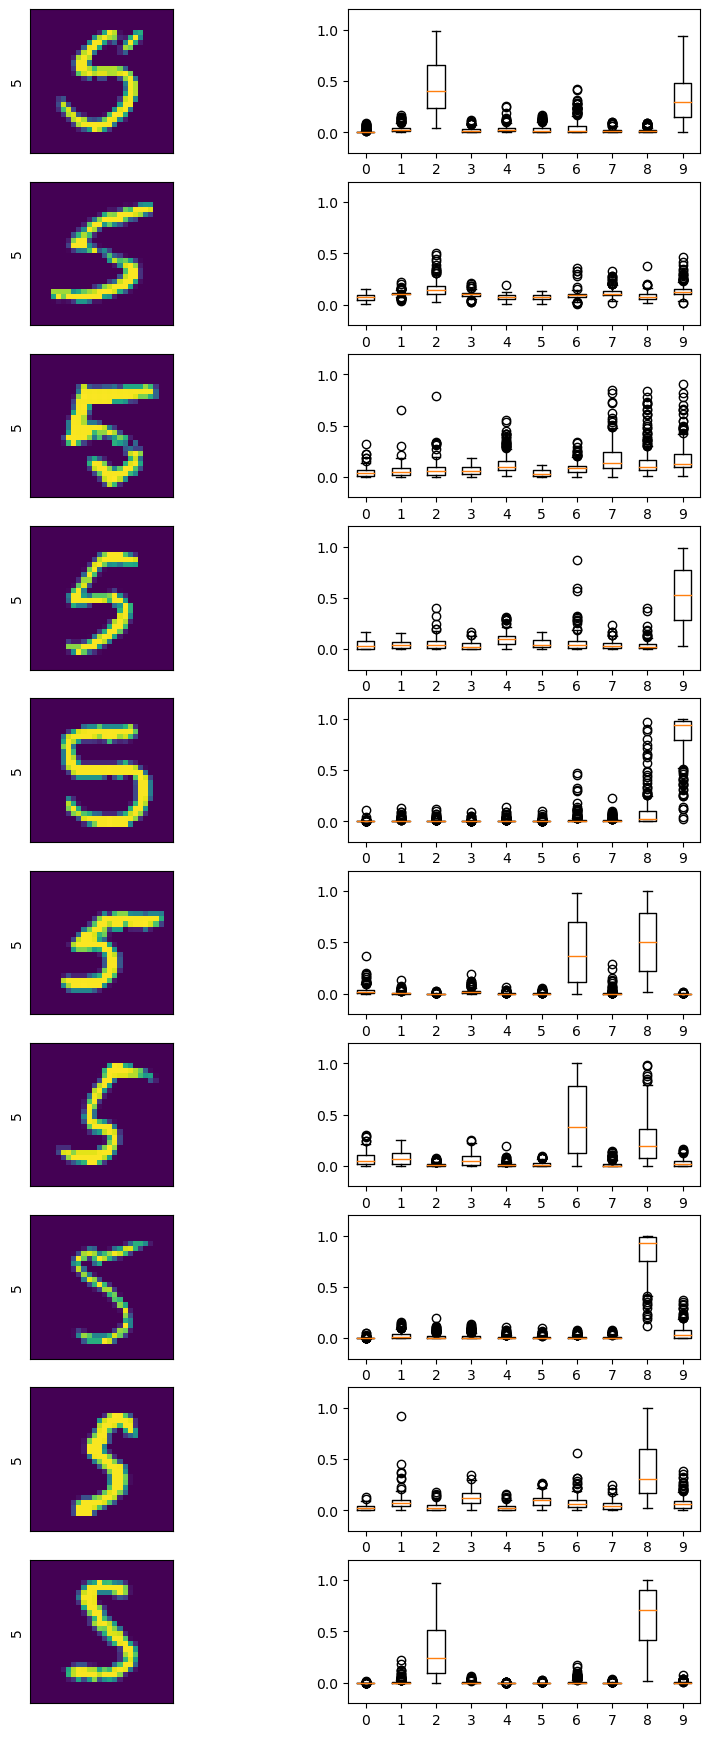

In [7]:
# Pick n test images and sample each num_samples times
# To select only a certain class, assign filter_class the corresponding number
num_images = 10
num_samples_per_image = 256
select_class = 5

_, test = make_mnist()
images, labels, samples = run_model_on_data(model, test, num_images, num_samples_per_image, select_class)

# Show images alongside Whisker plots
show_images(images, samples, labels)

[1] Ritter, Hippolyt, Aleksandar Botev, and David Barber. "A scalable laplace approximation for neural networks." 6th International Conference on Learning Representations, ICLR 2018-Conference Track Proceedings. Vol. 6. International Conference on Representation Learning, 2018.